In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import re
from tifffile import imread
from sklearn import preprocessing
import math
import scipy
from scipy.sparse import csgraph
from scipy.signal import windows
from scipy import stats
import seaborn as sns
import networkx as nx

from sklearn.metrics import pairwise_distances

# local imports
sys.path.append('../')
import cyclePred as cp

In [2]:
FILE = "B2"

"""load the cells """
fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/segmentation/{FILE}.celldata.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")


"""Load the tracks """
fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/tracks/{FILE}.tracks.full.csv"
tdf = pd.read_csv(fpath)

# add the cycle delineation
alpha = 0.05
tdf = cp.getPhases(tdf, alpha, correct=True)

# add track length and time variables
minsPerFrame = 20
tdf['trackLen'] = tdf.groupby('ID')['x'].transform('count')
tdf['Time'] = (tdf['t'] * minsPerFrame) / 60

print(f"{tdf.shape=}")
print()
print(tdf.columns)
tdf.head()

cdf.shape=(617561, 20)
alpha=0.05 ntests=1853109 2.767958806604298e-08
tdf.shape=(619829, 47)

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'prob', 'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_prepared', 'c1_logFoldChange_prepared',
       'c2_logFoldChange_prepared', 'c0_pval_prepared', 'c1_pval_prepared',
       'c2_pval_prepared', 'c0_logFoldChange_processed',
       'c1_logFoldChange_processed', 'c2_logFoldChange_processed',
       'c0_pval_processed', 'c1_pval_processed', 'c2_pval_processed', 'phase',
       'trackLen', 'Time'],
      dtype='object')


,ID,t,x,y,z,parent,root,state,generation,dummy,...,c2_pval_prepared,c0_logFoldChange_processed,c1_logFoldChange_processed,c2_logFoldChange_processed,c0_pval_processed,c1_pval_processed,c2_pval_processed,phase,trackLen,Time
0,1208,0,487.900000,993.850000,0.0,1208,1208,5,0,False,...,1.0,3.192239,1.601672,0.355895,1.675647e-19,1.510950e-17,3.639229e-04,G1,123,0.0
1,2819,0,1480.298969,441.402062,0.0,2819,2819,5,0,False,...,1.0,2.224389,1.194997,-0.700753,5.455167e-16,2.369958e-16,1.000000e+00,G1,105,0.0
2,2870,0,1471.841270,399.904762,0.0,2870,2870,5,0,False,...,1.0,3.169617,1.852023,1.144353,1.709204e-16,3.294425e-14,2.530034e-09,G1/S,144,0.0
3,3201,0,750.197183,321.830986,0.0,3201,3201,5,0,False,...,1.0,-0.614254,2.182702,3.500458,1.000000e+00,1.194510e-19,1.223147e-21,S/G2/M,5,0.0
4,2505,0,1381.858974,81.897436,0.0,2505,2505,5,0,False,...,1.0,2.717814,1.250783,-0.260879,3.781436e-13,1.659851e-15,9.997323e-01,G1,144,0.0


In [3]:
print(f"{tdf['ID'].nunique()=}")
fdf = tdf[tdf['trackLen'] == tdf['trackLen'].max()]
print(f"{fdf['ID'].nunique()=}")

tdf['ID'].nunique()=28262
fdf['ID'].nunique()=421


In [4]:
fdf['dummy'].value_counts()

dummy
False    60621
True         3
Name: count, dtype: int64

   Time        FN
0     0  0.744637
1     1  0.744671
2     2  0.744623
3     3  0.744480
4     4  0.744518


<AxesSubplot: xlabel='Time', ylabel='FN'>

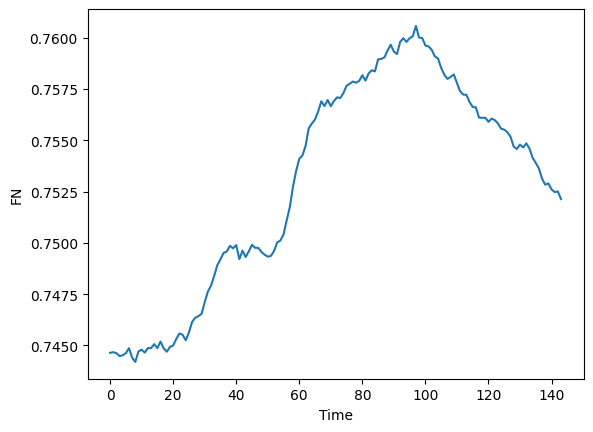

In [5]:
thresh = 1000

res = []

for t in fdf['t'].unique():
    frame = fdf[fdf['t'] == t]
    frame = frame.sort_values(by='ID')
    A = pairwise_distances(frame[['x', 'y']])

    A = np.where(A < thresh, 1, 0)
    L = csgraph.laplacian(A, normed=True)

    eigs, evals = np.linalg.eigh(L)


    row = {
        'Time' : t,
        'FN' : eigs[1],
    }
    
    res.append(row)
    
res = pd.DataFrame(res)
print(res.head())

sns.lineplot(data=res, x='Time', y='FN')